## sLDSC GWAS specific Analysis
Author: Ru Feng and Jenny Empawi

### Meta traits

#### Load libaries

In [26]:
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(colorspace)
library(ggpubr)
library(tidyverse)
library(dplyr)
library(showtext)
font_add_google("Noto Sans", "Noto Sans")
showtext_auto()

#### Load and prepare data

In [27]:
#studies <- c('ROSMAP_gpQTL_glycosylation_unadjusted') ## change context
#all_studies <- list.dirs("/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_sLDSC/SLDSC_ADSP_1000G_output/output",full.names = F,recursive = F) # All QTL studies - path in BU cluster

all_studies <- list.dirs("/data/resource/staging_files/SLDSC_ADSP_1000G_output/output",full.names = F,recursive = F) # path in cloud


studies <- all_studies[all_studies != "qtl.joint_tau"]

In [28]:
# res.dir <- "./" ## change path
#res.dir <- "/restricted/projectnb/xqtl/jaempawi/xqtl/Figure_sLDSC/SLDSC_ADSP_1000G_output/output/" # Please untar the tar.gz filer.gz #FIXME
res.dir <- "/data/resource/staging_files/SLDSC_ADSP_1000G_output/output/" # path in cloud

tau.list <- list()
enrich.list <- list()
for (study in studies) {
  # meta.dir <- paste0(res.dir, study, "/sumstats/all_m/processed_stats_2/single_tau.",study, ".meta_processed_stats.rds")
  meta.dir <- paste0(res.dir, study, "/sumstats/processed_stats_2/single_tau.",study, ".meta_processed_stats.rds") #FIXME
  metas <- readRDS(meta.dir)
  tau.list[[study]] <- data.frame(metas$tau)
  tau.list[[study]]$study <- study
  tau.list[[study]]$trait <- rownames(tau.list[[study]])
  enrich.list[[study]] <- data.frame(metas$enrichment)
  enrich.list[[study]]$study <- study
  enrich.list[[study]]$trait <- rownames(enrich.list[[study]])
  
}

In [29]:
tau.df <- do.call(rbind, tau.list)
enrich.df <- do.call(rbind, enrich.list)

# 95% confidence interval
tau.df$Lower <- tau.df$Mean - 1.96*tau.df$SD
tau.df$Upper <- tau.df$Mean + 1.96*tau.df$SD
tau.df$signif <- tau.df$P < 0.05
enrich.df$Lower <- enrich.df$Mean - 1.96*enrich.df$SD
enrich.df$Upper <- enrich.df$Mean + 1.96*enrich.df$SD
enrich.df$signif <- enrich.df$P < 0.05



In [30]:
reorder_levels <- tau.df %>%
  filter(trait == "Brain") %>%          # choose reference trait
  arrange(desc(Mean)) %>%               # descending by Mean
  pull(study) %>%                       # get vector
  unique()

tau.df$study <- factor(tau.df$study, levels = reorder_levels)

#### Marginal tau

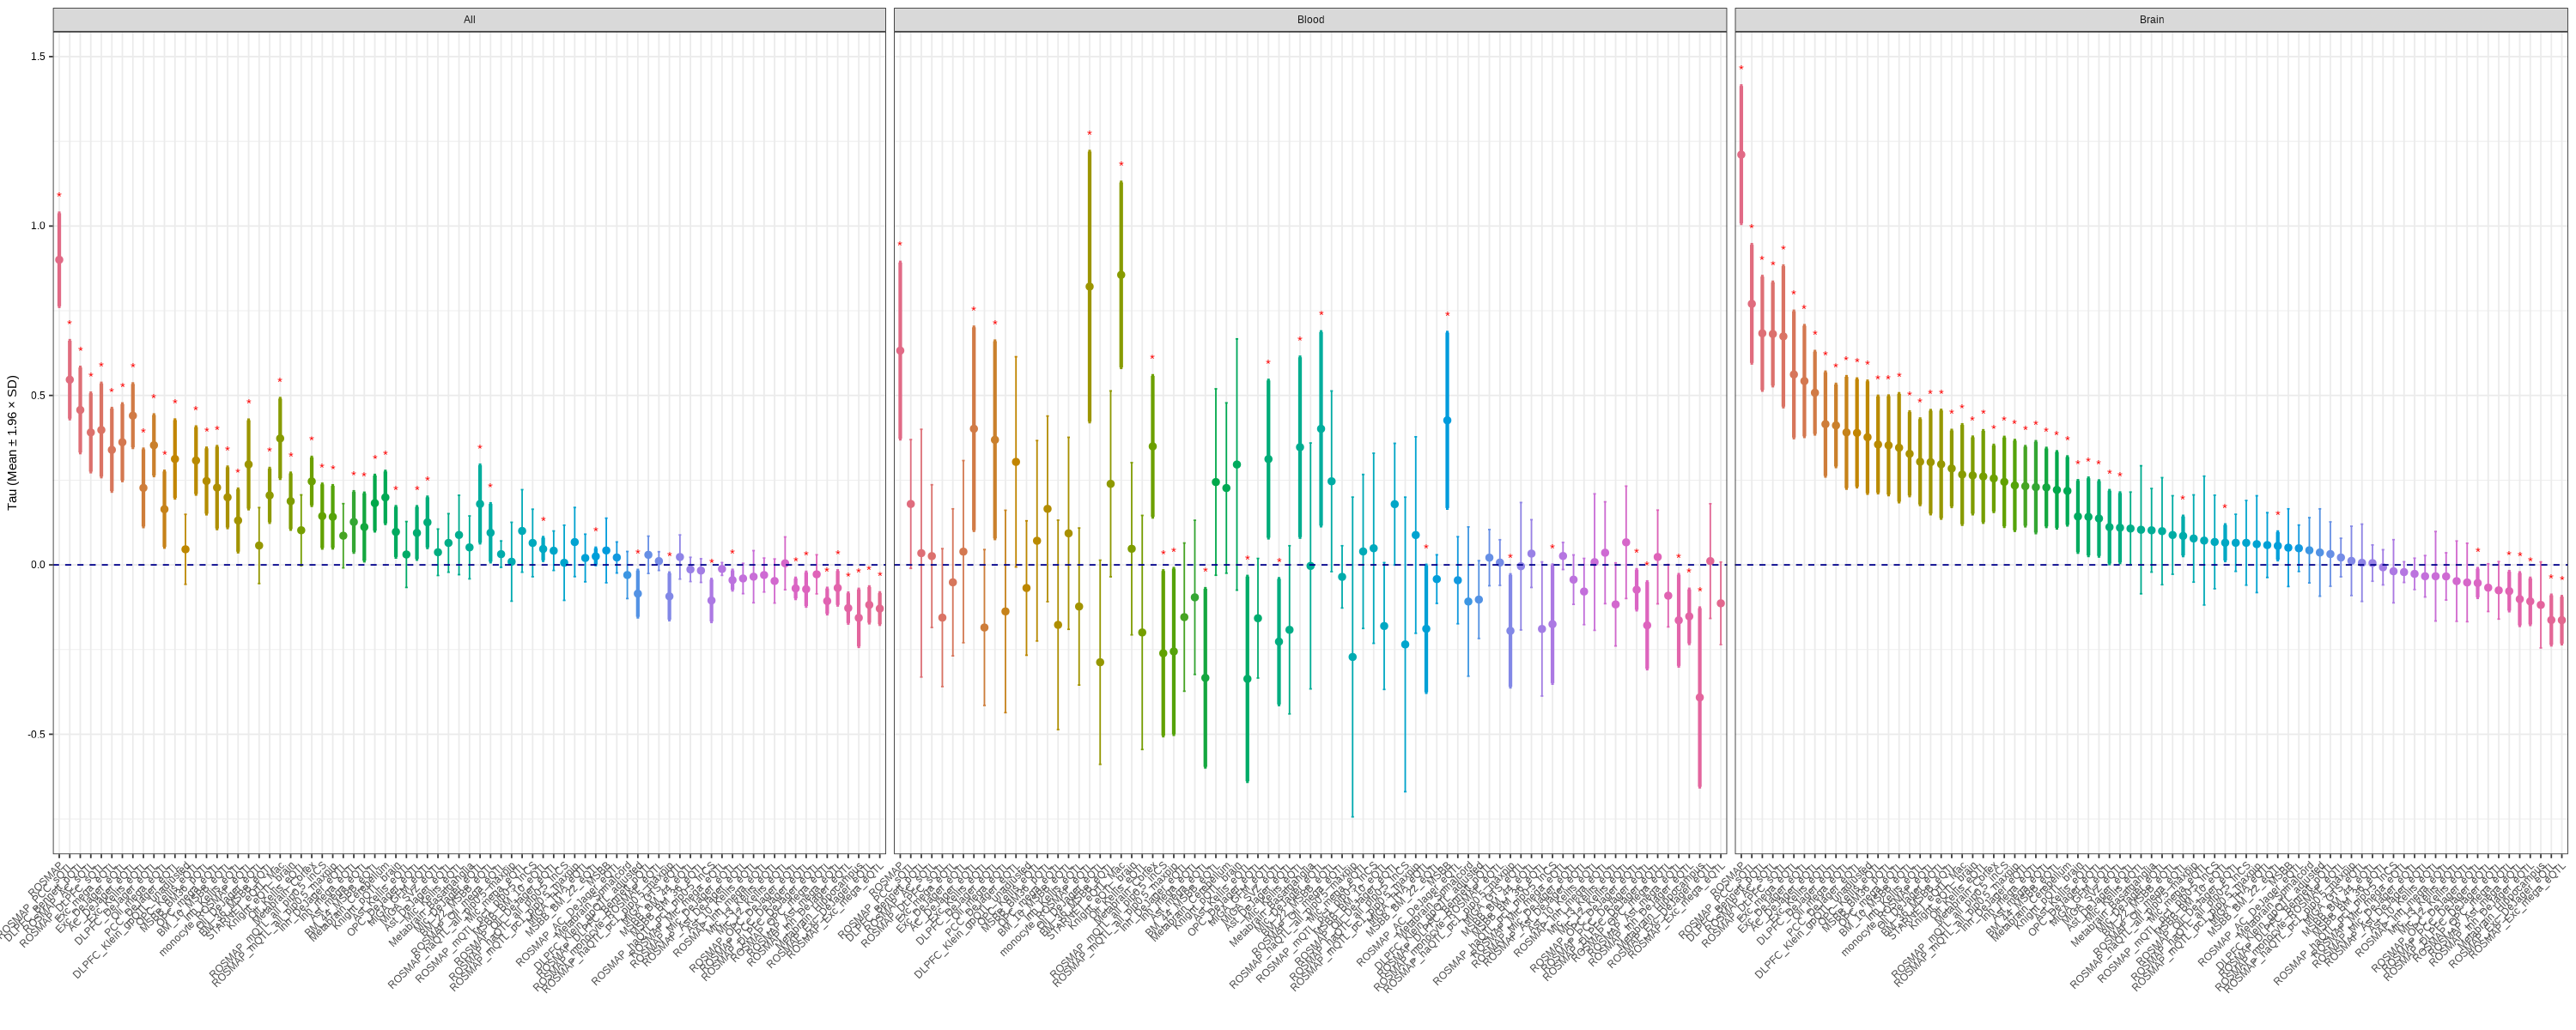

In [31]:
## 5. Mark significance (95 % CI does NOT include zero) ---------
tau.df <- tau.df %>%
  mutate(signif = Lower * Upper > 0)

## 6. Prepare a colour palette ---------------------------------
all_colors <- qualitative_hcl(
  n = length(levels(tau.df$study)),
  palette = "Dark 3"
)

## 7. Plot marginal_tau -------------------------------------------------------
p1 <- ggplot(
  tau.df,
  aes(x = study, y = Mean,
      colour = study, group = trait)         
) +
  # point estimates
  geom_point(
    position = position_dodge(width = 0.6),
    size = 2
  ) +
  # error bars (95 % CI)
  geom_errorbar(
    aes(ymin = Lower, ymax = Upper,
        linewidth = signif),               # thick if significant
    position = position_dodge(width = 0.6),
    width = 0.25
  ) +
  # asterisks on significant estimates
  geom_text(
    data = subset(tau.df, signif),
    aes(label = "*", y = Upper + 0.05),
    position = position_dodge(width = 0.6),
    colour = "red", size = 4
  ) +
  # colour & linewidth scales
  scale_color_manual(values = all_colors) +
  scale_linewidth_manual(values = c(`TRUE` = 1.2, `FALSE` = 0.5)) +
  # horizontal zero line
  geom_hline(yintercept = 0, linetype = 2, colour = "darkblue") +
  # theme tweaks
  theme_bw() +
  theme(
    axis.text.x  = element_text(angle = 45, hjust = 1, vjust = 1),
    axis.text.y  = element_text(size = 9,  colour = "black"),
    axis.title.x = element_blank(),
    legend.position = "none"
  ) +
  # axis title
  ylab("Tau (Mean ± 1.96 × SD)") + facet_wrap(~trait)

## 8. Display plot ----------------------------------------------
print(p1)


#### Enrichment

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


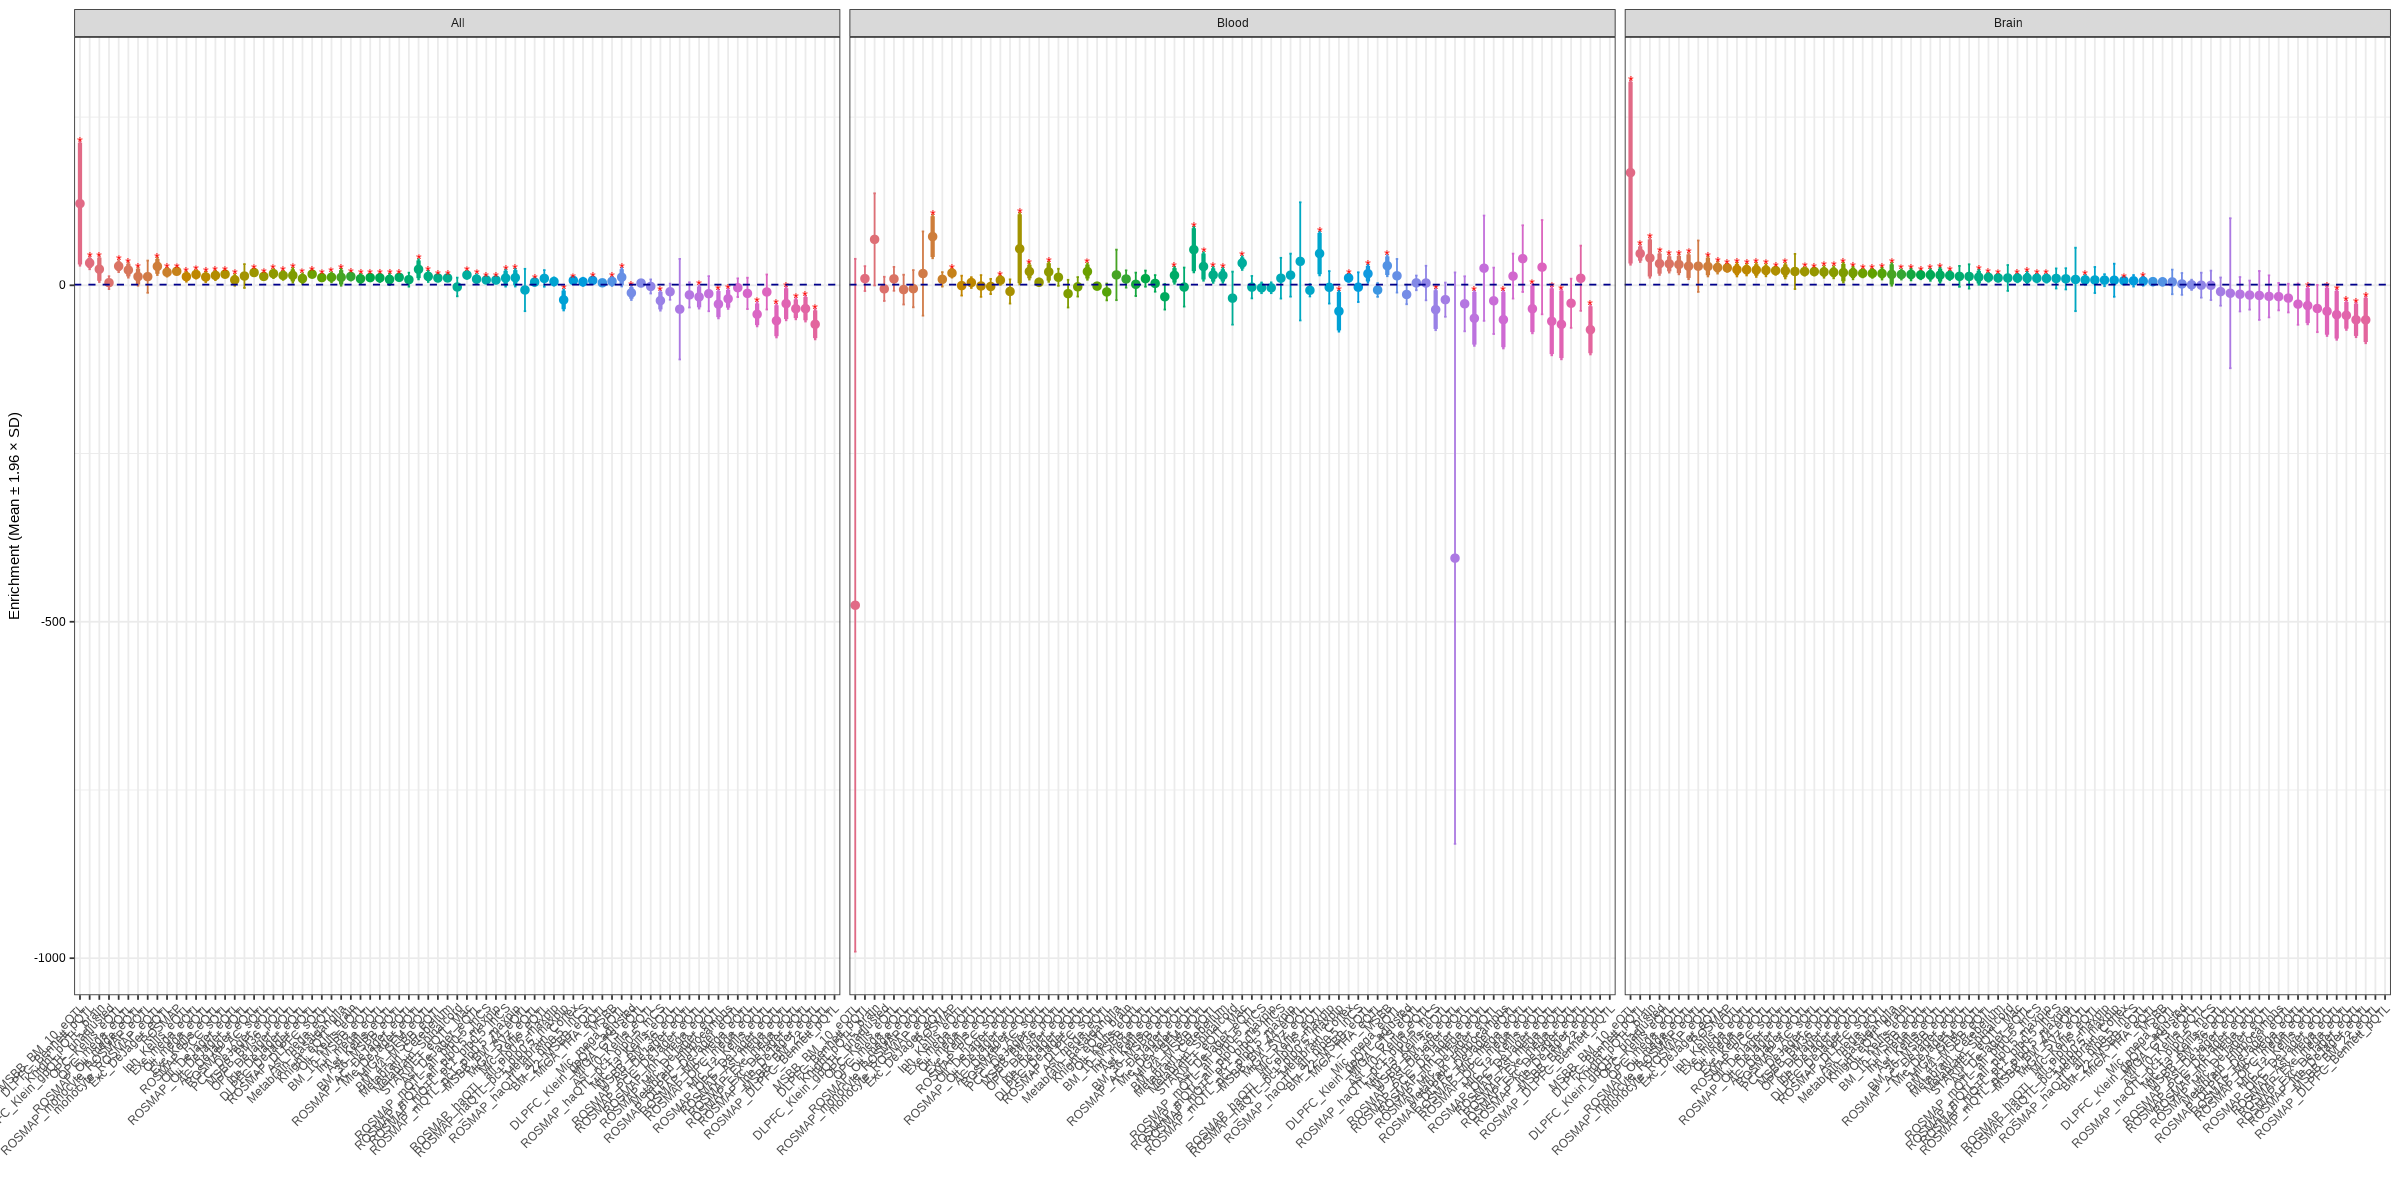

In [32]:
## Enrichment
reorder_levels <- enrich.df %>%
  filter(trait == "Brain") %>%          # choose reference trait
  arrange(desc(Mean)) %>%               # descending by Mean
  pull(study) %>%                       # get vector
  unique()

enrich.df$study <- factor(enrich.df$study, levels = reorder_levels)

## 5. Mark significance (95 % CI does NOT include zero) ---------
enrich.df <- enrich.df %>%
  mutate(signif = Lower * Upper > 0)

## 6. Prepare a colour palette ---------------------------------
all_colors <- qualitative_hcl(
  n = length(levels(enrich.df$study)),
  palette = "Dark 3"
)

## 7. Plot Enrichment-------------------------------------------------------
p2 <- ggplot(
  enrich.df,
  aes(x = study, y = Mean,
      colour = study)      
) +
  # point estimates
  geom_point(
    position = position_dodge(width = 0.6),
    size = 2
  ) +
  # error bars (95 % CI)
  geom_errorbar(
    aes(ymin = Lower, ymax = Upper,
        linewidth = signif),               # thick if significant
    position = position_dodge(width = 0.6),
    width = 0.25
  ) +
  # asterisks on significant estimates
  geom_text(
    data = subset(enrich.df, signif),
    aes(label = "*", y = Upper + 2),
    position = position_dodge(width = 0.6),
    colour = "red", size = 4
  ) +
  # colour & linewidth scales
  scale_color_manual(values = all_colors) +
  scale_linewidth_manual(values = c(`TRUE` = 1.2, `FALSE` = 0.5)) +
  # horizontal zero line
  geom_hline(yintercept = 1, linetype = 2, colour = "darkblue") +
  # theme tweaks
  theme_bw() +
  theme(
    axis.text.x  = element_text(angle = 45, hjust = 1, vjust = 1),
    axis.text.y  = element_text(size = 9,  colour = "black"),
    axis.title.x = element_blank(),
    legend.position = "none"
  ) +
  # axis title
  ylab("Enrichment (Mean ± 1.96 × SD)") + facet_wrap(~trait)


options(repr.plot.width = 20, repr.plot.height = 10) 
## 8. Display plot ----------------------------------------------
print(p2)

### Seprate traits

#### Load data and prepare data

In [33]:
# ttmp <- readRDS('./ROSMAP_gpQTL_glycosylation_unadjusted.single_tau.initial_processed_stats.rds')
ttmp <- readRDS(paste0(res.dir, study, "/sumstats/", study, ".single_tau.initial_processed_stats.rds")) 

In [34]:
blood_traits <- c('UKB.Lym.BOLT.sumstats.parquet','UKB.Mono.BOLT.sumstats.parquet','UKB.Plt.BOLT.sumstats.parquet','UKB.RBC.BOLT.sumstats.parquet','UKB_460K.blood_RBC_DISTRIB_WIDTH.sumstats.parquet','UKB.Eosino.BOLT.sumstats.parquet','UKB.Baso.BOLT.sumstats.parquet','UKB.Neutro.BOLT.sumstats.parquet','UKB.MCV.BOLT.sumstats.parquet','PASS_IBD_deLange2017.sumstats.parquet','PASS_CD_deLange2017.sumstats.parquet','PASS_UC_deLange2017.sumstats.parquet','UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED.sumstats.parquet','UKB.Hypothyroidism.SAIGE.sumstats.parquet','PASS_Rheumatoid_Arthritis.sumstats.parquet','PASS_Primary_biliary_cirrhosis.sumstats.parquet','PASS_Lupus.sumstats.parquet','PASS_Type_1_Diabetes.sumstats.parquet','UKB.AID_Combined.SAIGE.sumstats.parquet','PASS_Celiac.sumstats.parquet')
brain_traits <- c('AD_Bellenguez_buildGRCh38_munged.parquet', 'AD_Wightman_Excluding23andMe_hg38_sorted_munged.parquet', 'AD_Bellenguez_EADB_hg38_sorted_munged.parquet', 'AD_Wightman_ExcludingUKB23andMe_hg38_sorted_munged.parquet','AD_Kunkle_etal_Stage1_results_hg38.sorted.munged.parquet', 'AD_Wightman_full_2021_munged.parquet', 'PASS_Alzheimers_Jansen2019.sumstats.parquet','EXF.sumstats.parquet','LAN.sumstats.parquet','MEM.sumstats.parquet','MS.sumstats.parquet','accumbens.sumstats.parquet','ALS-Rheenen-2021.GCST90027163_buildGRCh37.sumstats.parquet','ALS-Rheenen-2021.GCST90027164_buildGRCh37.sumstats.parquet','amygdala.sumstats.parquet','brainstem.sumstats.parquet','caudate.sumstats.parquet','nallsEtAl2019_excluding23andMe.sumstats.parquet','neuroticism_ctg.sumstats.parquet','pallidum.sumstats.parquet','PGC3_SCZ_wave3_public.v2.sumstats.parquet','PGC_UKB_23andMe_depression_10000.sumstats.parquet','PGC_UKB_depression_genome-wide.sumstats.parquet','putamen.sumstats.parquet','rmf.surf.sumstats.parquet','rmf.thick.sumstats.parquet','sf.surf.sumstats.parquet','sf.thick.sumstats.parquet','image_AD1.sumstats.parquet','image_Aging2.sumstats.parquet','image_Aging5.sumstats.parquet','image_AD2.sumstats.parquet','image_Aging3.sumstats.parquet','image_Aging1.sumstats.parquet','image_Aging4.sumstats.parquet','UKB_460K.repro_NumberChildrenEverBorn_Pooled.sumstats.parquet','PASS_Anorexia.sumstats.parquet','PASS_ADHD_Demontis2018.sumstats.parquet','PASS_Autism.sumstats.parquet','PASS_SleepDuration_Dashti2019.sumstats.parquet','UKB.BMI.BOLT.sumstats.parquet','PASS_MDD_Wray2018.sumstats.parquet','PASS_Neuroticism.sumstats.parquet','UKB.Smoking_Ever_Never.SAIGE.sumstats.parquet','UKB_460K.cov_EDU_YEARS.sumstats.parquet','PASS_Intelligence_SavageJansen2018.sumstats.parquet','UKB.Morning_Person.BOLT.sumstats.parquet','UKB.Insomnia.BOLT.sumstats.parquet','PASS_Schizophrenia.sumstats.parquet','PASS_SCZvsBD_Ruderfer2018.sumstats.parquet','PASS_BipolarDisorder_Ruderfer2018.sumstats.parquet','PASS_ReactionTime_Davies2018.sumstats.parquet','PASS_AgeFirstBirth.sumstats.parquet','PASS_Multiple_sclerosis.sumstats.parquet')
all_traits <- c('AD_Bellenguez_buildGRCh38_munged.parquet', 'AD_Wightman_Excluding23andMe_hg38_sorted_munged.parquet', 'AD_Bellenguez_EADB_hg38_sorted_munged.parquet', 'AD_Wightman_ExcludingUKB23andMe_hg38_sorted_munged.parquet','AD_Kunkle_etal_Stage1_results_hg38.sorted.munged.parquet', 'AD_Wightman_full_2021_munged.parquet', 'PASS_Alzheimers_Jansen2019.sumstats.parquet','EXF.sumstats.parquet','LAN.sumstats.parquet','MEM.sumstats.parquet','MS.sumstats.parquet','accumbens.sumstats.parquet','ALS-Rheenen-2021.GCST90027163_buildGRCh37.sumstats.parquet','ALS-Rheenen-2021.GCST90027164_buildGRCh37.sumstats.parquet','amygdala.sumstats.parquet','brainstem.sumstats.parquet','caudate.sumstats.parquet','GWAS_CP_all.sumstats.parquet','GWAS_EA_excl23andMe.sumstats.parquet','MegaGWAS_summary_European.sumstats.parquet','nallsEtAl2019_excluding23andMe.sumstats.parquet','neuroticism_ctg.sumstats.parquet','pallidum.sumstats.parquet','PGC3_SCZ_wave3_public.v2.sumstats.parquet','PGC_UKB_23andMe_depression_10000.sumstats.parquet','PGC_UKB_depression_genome-wide.sumstats.parquet','putamen.sumstats.parquet','rmf.surf.sumstats.parquet','rmf.thick.sumstats.parquet','sf.surf.sumstats.parquet','sf.thick.sumstats.parquet','image_AD1.sumstats.parquet','image_Aging2.sumstats.parquet','image_Aging5.sumstats.parquet','image_AD2.sumstats.parquet','image_Aging3.sumstats.parquet','image_Aging1.sumstats.parquet','image_Aging4.sumstats.parquet','UKB.Lym.BOLT.sumstats.parquet','UKB.Mono.BOLT.sumstats.parquet','UKB.Plt.BOLT.sumstats.parquet','UKB.RBC.BOLT.sumstats.parquet','UKB_460K.blood_RBC_DISTRIB_WIDTH.sumstats.parquet','UKB.Eosino.BOLT.sumstats.parquet','UKB.Baso.BOLT.sumstats.parquet','UKB.Neutro.BOLT.sumstats.parquet','UKB.MCV.BOLT.sumstats.parquet','UKB_460K.biochemistry_Creatinine.sumstats.parquet','UKB.VitD.BOLT.sumstats.parquet','UKB.TBil.BOLT.sumstats.parquet','UKB_460K.biochemistry_AlkalinePhosphatase.sumstats.parquet','UKB_460K.biochemistry_AspartateAminotransferase.sumstats.parquet','UKB.TP.BOLT.sumstats.parquet','PASS_IBD_deLange2017.sumstats.parquet','PASS_CD_deLange2017.sumstats.parquet','PASS_UC_deLange2017.sumstats.parquet','UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED.sumstats.parquet','UKB.Hypothyroidism.SAIGE.sumstats.parquet','PASS_Rheumatoid_Arthritis.sumstats.parquet','PASS_Primary_biliary_cirrhosis.sumstats.parquet','PASS_Lupus.sumstats.parquet','PASS_Type_1_Diabetes.sumstats.parquet','UKB.AID_Combined.SAIGE.sumstats.parquet','PASS_Celiac.sumstats.parquet','PASS_Alzheimers_Jansen2019.sumstats.parquet','PASS_Multiple_sclerosis.sumstats.parquet','UKB_460K.repro_NumberChildrenEverBorn_Pooled.sumstats.parquet','PASS_Anorexia.sumstats.parquet','PASS_ADHD_Demontis2018.sumstats.parquet','PASS_Autism.sumstats.parquet','PASS_SleepDuration_Dashti2019.sumstats.parquet','UKB.BMI.BOLT.sumstats.parquet','PASS_MDD_Wray2018.sumstats.parquet','PASS_Neuroticism.sumstats.parquet','UKB.Smoking_Ever_Never.SAIGE.sumstats.parquet','UKB_460K.cov_EDU_YEARS.sumstats.parquet','PASS_Intelligence_SavageJansen2018.sumstats.parquet','UKB.Morning_Person.BOLT.sumstats.parquet','UKB.Insomnia.BOLT.sumstats.parquet','PASS_Schizophrenia.sumstats.parquet','PASS_SCZvsBD_Ruderfer2018.sumstats.parquet','PASS_BipolarDisorder_Ruderfer2018.sumstats.parquet','PASS_ReactionTime_Davies2018.sumstats.parquet','PASS_AgeFirstBirth.sumstats.parquet','CAD_META.filtered.sumstats.parquet','UKB_460K.bp_SYSTOLICadjMEDz.sumstats.parquet','UKB_460K.bp_DIASTOLICadjMEDz.sumstats.parquet','PASS_ChildOnsetAsthma_Ferreira2019.sumstats.parquet','UKB.FEV1FVC.BOLT.sumstats.parquet','PASS_Height1.sumstats.parquet','UKB.BrC.SAIGE.sumstats.parquet','UKB.WHRadjBMI.BOLT.sumstats.parquet','Mahajan.NatGenet2018b.T2D.European.sumstats.parquet','UKB_460K.impedance_BASAL_METABOLIC_RATEz.sumstats.parquet','PASS_GeneralRiskTolerance_KarlssonLinner2019.sumstats.parquet')

In [35]:
traits_dt <- rbindlist(lapply(seq_along(ttmp), function(i) {
  res <- ttmp[[i]]
   enr <- res$enrichment$enrichment_summary
  data.table(
    trait = names(ttmp)[i],
    enrichment = enr$Enrichment.Enrichment,
    se = enr$Enrichment_std_error.Enrichment_std_error,
    prop_h2 = enr$`Prop._h2.Prop._h2`,
    prop_snps = enr$`Prop._SNPs.Prop._SNPs`,
    p = enr$Enrichment_p,
    enrich_z = res$meta_enrstat$enrich_z,
    h2g = res$single_tau$h2g,
    sd_annot =as.numeric(res$single_tau$sd_annot)
  )
}))

In [36]:
traits_dt <- traits_dt %>% mutate(category = ifelse(trait %in% blood_traits, 'Blood', 
                                      ifelse(trait %in% brain_traits, 'Brain', 
                                      ifelse(trait %in% all_traits, 'Others', NA))))

In [37]:
traits_dt$trait <- gsub('.sumstats.parquet', '', traits_dt$trait)
traits_dt$trait <- gsub('.munged.parquet', '', traits_dt$trait)
traits_dt$trait <- gsub('_munged.parquet', '', traits_dt$trait)

In [38]:
trait_names <- c(

  # Alzheimer’s/ Dementia / FTD & neurological disorders
  "PASS_Alzheimers_Jansen2019" = "Alzheimer's Disease (Jansen 2019)",
  "PASS_Multiple_sclerosis"    = "Multiple Sclerosis",
  "AD_Bellenguez_buildGRCh38"                    = "Alzheimer's Disease (Bellenguez)",
  "AD_Wightman_Excluding23andMe_hg38_sorted"     = "Alzheimer's Disease (Wightman excl. 23andMe)",
  "AD_Bellenguez_EADB_hg38_sorted"               = "Alzheimer's Disease (Bellenguez EADB)",
  "AD_Wightman_ExcludingUKB23andMe_hg38_sorted"  = "Alzheimer's Disease (Wightman excl. UKB & 23andMe)",
  "AD_Kunkle_etal_Stage1_results_hg38.sorted"    = "Alzheimer's Disease (Kunkle Stage 1)",
  "AD_Wightman_full_2021"                        = "Alzheimer's Disease (Wightman Full)",

  # Brain structures / imaging / neuro
  "EXF"                        = "Executive Function",
  "LAN"                        = "Language",
  "MEM"                        = "Memory",
  "MS"                         = "Multiple Sclerosis (from Lu)",
  "accumbens"                  = "Nucleus Accumbens Volume",
  "ALS-Rheenen-2021.GCST90027163_buildGRCh37" = "ALS (Rheenen 2021, GWAS1)",
  "ALS-Rheenen-2021.GCST90027164_buildGRCh37" = "ALS (Rheenen 2021, GWAS2)",
  "amygdala"                   = "Amygdala Volume",
  "brainstem"                  = "Brainstem Volume",
  "caudate"                    = "Caudate Volume",
  "GWAS_CP_all"                = "Cognitive Performance",
  "GWAS_EA_excl23andMe"        = "Educational Attainment (Excl. 23andMe)",
  "MegaGWAS_summary_European"  = "Cognitive Ability (European MegaGWAS)",
  "nallsEtAl2019_excluding23andMe" = "Parkinson's Disease (Nalls 2019 excl. 23andMe)",
  "neuroticism_ctg"            = "Neuroticism (CTG)",
  "pallidum"                   = "Pallidum Volume",
  "PGC3_SCZ_wave3_public.v2"   = "Schizophrenia (PGC3 Wave3)",
  "PGC_UKB_23andMe_depression_10000" = "Depression (PGC+UKB+23andMe)",
  "PGC_UKB_depression_genome-wide"   = "Depression (PGC+UKB GWAS)",
  "putamen"                    = "Putamen Volume",
  "rmf.surf"                   = "Rostral Middle Frontal Surface Area",
  "rmf.thick"                  = "Rostral Middle Frontal Thickness",
  "sf.surf"                    = "Superior Frontal Surface Area",
  "sf.thick"                   = "Superior Frontal Thickness",
  "image_AD1"                  = "Imaging Alzheimer's Set1",
  "image_AD2"                  = "Imaging Alzheimer's Set2",
  "image_Aging1"               = "Imaging Aging Set1",
  "image_Aging2"               = "Imaging Aging Set2",
  "image_Aging3"               = "Imaging Aging Set3",
  "image_Aging4"               = "Imaging Aging Set4",
  "image_Aging5"               = "Imaging Aging Set5",

  # Blood-related traits
  "UKB.Lym.BOLT"               = "UKB Lymphocyte Count",
  "UKB.Mono.BOLT"              = "UKB Monocyte Count",
  "UKB.Plt.BOLT"               = "UKB Platelet Count",
  "UKB.RBC.BOLT"               = "UKB RBC Count",
  "UKB_460K.blood_RBC_DISTRIB_WIDTH" = "UKB RBC Distribution Width",
  "UKB.Eosino.BOLT"            = "UKB Eosinophil Count",
  "UKB.Baso.BOLT"              = "UKB Basophil Count",
  "UKB.Neutro.BOLT"            = "UKB Neutrophil Count",
  "UKB.MCV.BOLT"               = "UKB Mean Corpuscular Volume",
  "UKB_460K.biochemistry_Creatinine" = "UKB Serum Creatinine",
  "UKB.VitD.BOLT"              = "UKB Vitamin D",
  "UKB.TBil.BOLT"              = "UKB Total Bilirubin",
  "UKB_460K.biochemistry_AlkalinePhosphatase" = "UKB Alkaline Phosphatase",
  "UKB_460K.biochemistry_AspartateAminotransferase" = "UKB AST",
  "UKB.TP.BOLT"                = "UKB Total Protein",

  # Autoimmune & Inflammatory
  "PASS_IBD_deLange2017"       = "Inflammatory Bowel Disease (de Lange 2017)",
  "PASS_CD_deLange2017"        = "Crohn's Disease (de Lange 2017)",
  "PASS_UC_deLange2017"        = "Ulcerative Colitis (de Lange 2017)",
  "UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED" = "Allergy/Eczema (UKB)",
  "UKB.Hypothyroidism.SAIGE"   = "Hypothyroidism (UKB)",
  "PASS_Rheumatoid_Arthritis"  = "Rheumatoid Arthritis",
  "PASS_Primary_biliary_cirrhosis" = "Primary Biliary Cirrhosis",
  "PASS_Lupus"                 = "Systemic Lupus Erythematosus",
  "PASS_Type_1_Diabetes"       = "Type 1 Diabetes",
  "UKB.AID_Combined.SAIGE"     = "Combined Autoimmune Diseases (UKB)",
  "PASS_Celiac"                = "Celiac Disease",


  # Reproductive & psychiatric
  "UKB_460K.repro_NumberChildrenEverBorn_Pooled" = "Number of Children Ever Born",
  "PASS_Anorexia"              = "Anorexia Nervosa",
  "PASS_ADHD_Demontis2018"     = "ADHD (Demontis 2018)",
  "PASS_Autism"                = "Autism Spectrum Disorder",
  "PASS_SleepDuration_Dashti2019" = "Sleep Duration (Dashti 2019)",
  "UKB.BMI.BOLT"               = "UKB BMI",
  "PASS_MDD_Wray2018"          = "Major Depression (Wray 2018)",
  "PASS_Neuroticism"           = "Neuroticism (PASS)",
  "UKB.Smoking_Ever_Never.SAIGE" = "Smoking Ever/Never (UKB)",
  "UKB_460K.cov_EDU_YEARS"     = "Educational Years (UKB)",
  "PASS_Intelligence_SavageJansen2018" = "Intelligence (Savage & Jansen 2018)",
  "UKB.Morning_Person.BOLT"    = "Chronotype (Morning Person)",
  "UKB.Insomnia.BOLT"          = "Insomnia (UKB)",
  "PASS_Schizophrenia"         = "Schizophrenia",
  "PASS_SCZvsBD_Ruderfer2018"  = "Schizophrenia vs Bipolar (Ruderfer 2018)",
  "PASS_BipolarDisorder_Ruderfer2018" = "Bipolar Disorder (Ruderfer 2018)",
  "PASS_ReactionTime_Davies2018" = "Reaction Time (Davies 2018)",
  "PASS_AgeFirstBirth"         = "Age at First Birth",

  # Cardiometabolic & general health
  "CAD_META.filtered"          = "Coronary Artery Disease (Meta)",
  "UKB_460K.bp_SYSTOLICadjMEDz" = "Systolic BP (adj. meds)",
  "UKB_460K.bp_DIASTOLICadjMEDz" = "Diastolic BP (adj. meds)",
  "PASS_ChildOnsetAsthma_Ferreira2019" = "Childhood Onset Asthma (Ferreira 2019)",
  "UKB.FEV1FVC.BOLT"           = "FEV1/FVC Ratio (Lung Function)",
  "PASS_Height1"               = "Height",
  "UKB.BrC.SAIGE"              = "Breast Cancer (UKB)",
  "UKB.WHRadjBMI.BOLT"         = "Waist-Hip Ratio adj. BMI",
  "Mahajan.NatGenet2018b.T2D.European" = "Type 2 Diabetes (Mahajan 2018, European)",
  "UKB_460K.impedance_BASAL_METABOLIC_RATEz" = "Basal Metabolic Rate (UKB)",
  "PASS_GeneralRiskTolerance_KarlssonLinner2019" = "General Risk Tolerance (Karlsson Linner 2019)"
)

In [39]:
# replace codes with human-readable names
traits_dt <- traits_dt %>%
  mutate(trait = recode(trait, !!!trait_names))

In [40]:
traits_dt$category <- factor(traits_dt$category, levels = c('Brain', 'Blood', 'Others'))

In [41]:
head(traits_dt)

trait,enrichment,se,prop_h2,prop_snps,p,h2g,sd_annot,category
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Executive Function,47.062,198.600,0.0037062,7.8751e-05,0.818320,-0.4997,0.006778389,Brain
Language,186.650,96.120,0.0146990,7.8751e-05,0.052973,-1.0392,0.006778389,Brain
Memory,38.301,83.466,0.0030163,7.8751e-05,0.654800,-1.0016,0.006778389,Brain
Multiple Sclerosis (from Lu),98.475,73.171,0.0077550,7.8751e-05,0.181800,0.3672,0.006778389,Brain
Nucleus Accumbens Volume,44.794,101.330,0.0035276,7.8751e-05,0.661210,0.2397,0.006778389,Brain
"ALS (Rheenen 2021, GWAS1)",104.960,88.185,0.0082655,7.8751e-05,0.238750,0.1111,0.006778389,Brain


#### Plot 3

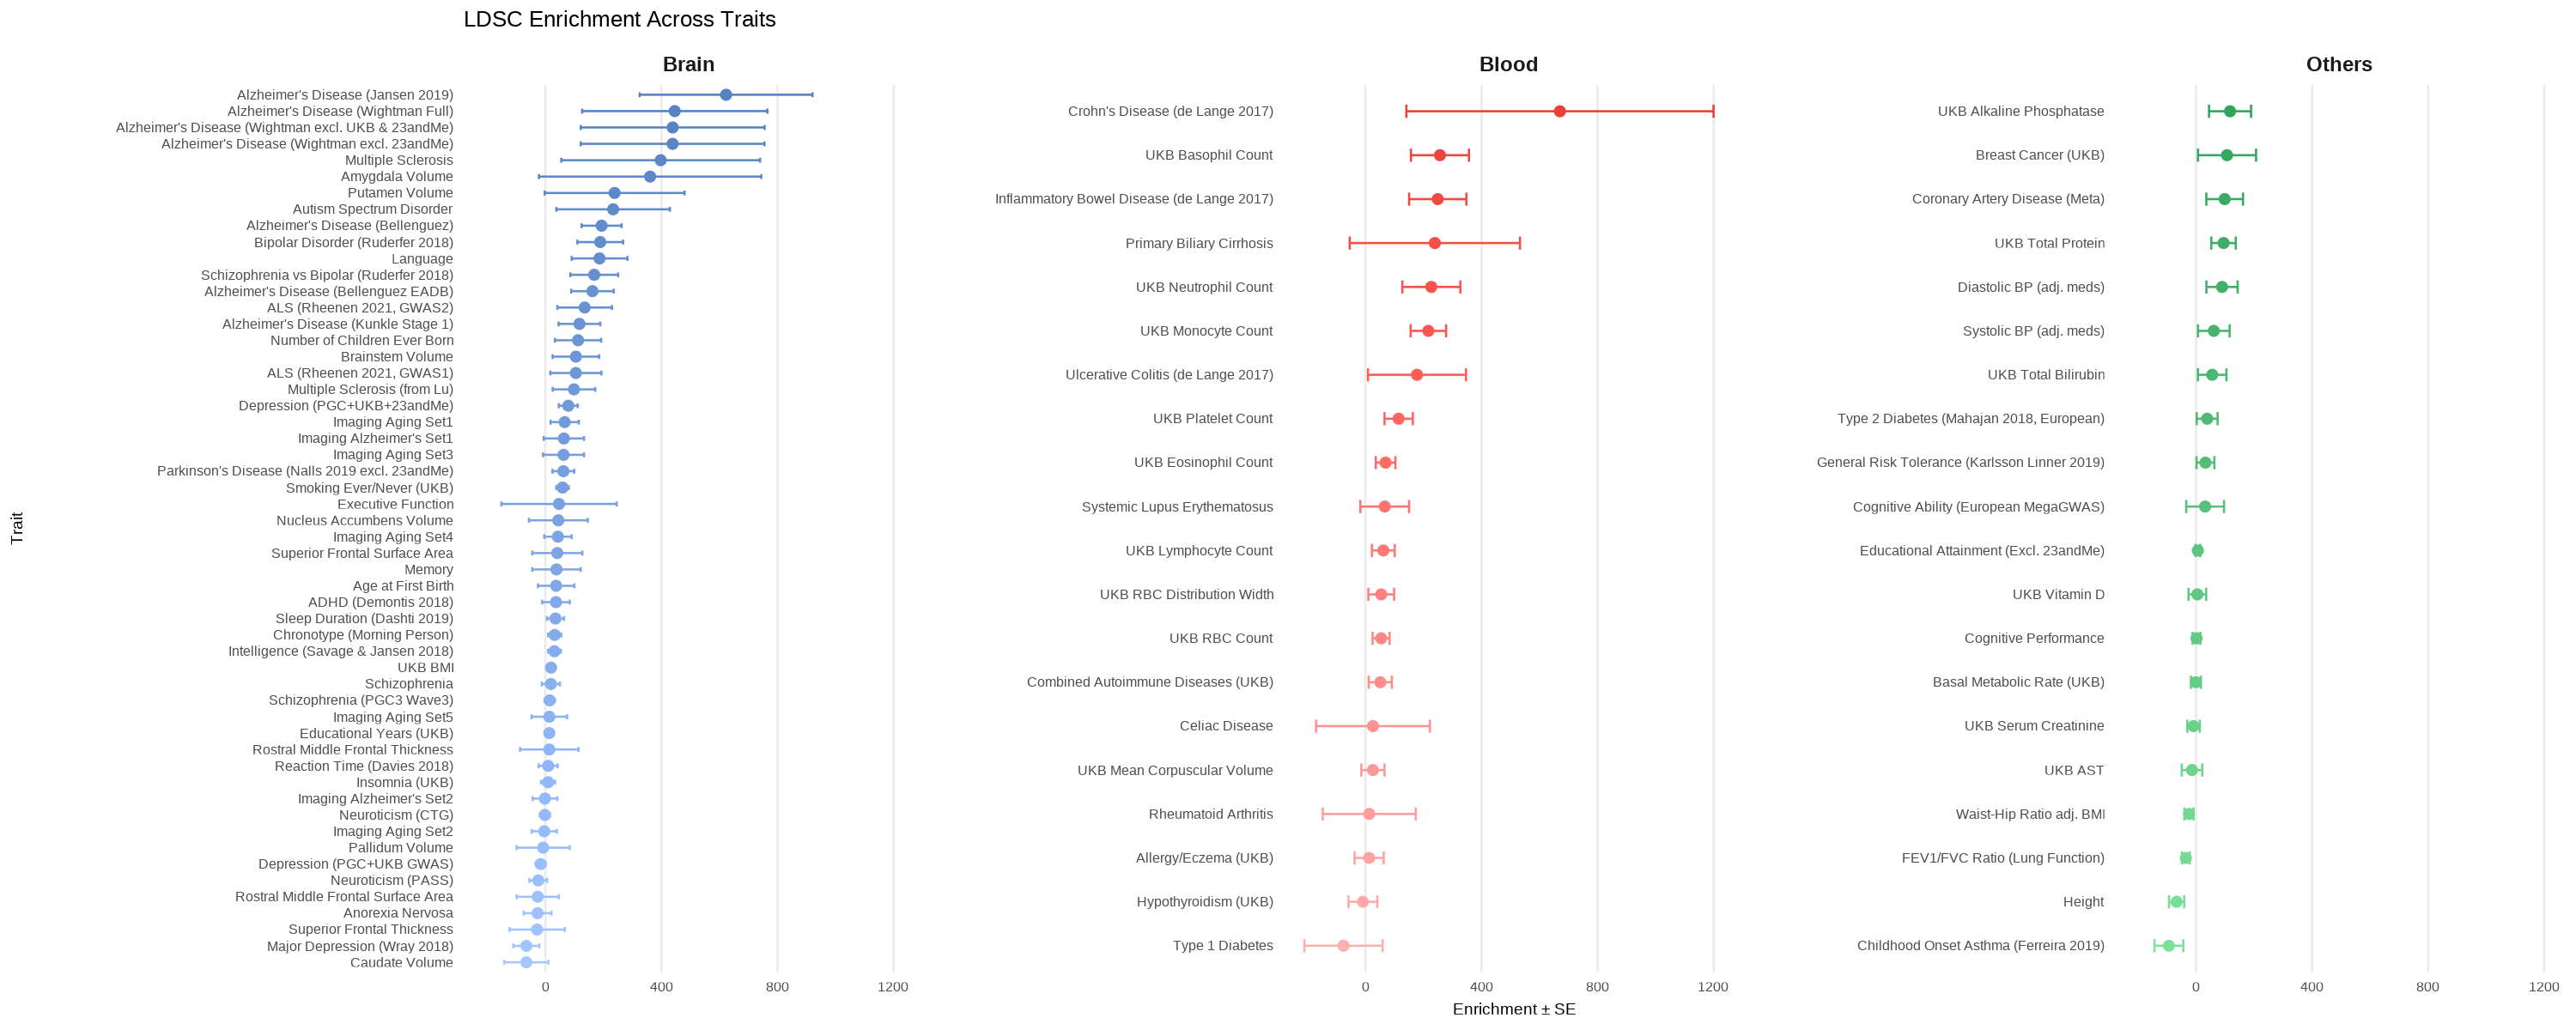

In [42]:
options(repr.plot.width = 25, repr.plot.height = 10)

category_colors <- c(
  "Blood" = "#4575B4",     # 
  "Brain" = "#D73027",     # 
  "All" = "#1A9850",    # 
  "Others" = "#984EA3"      # others
)

# Assign colors by category (soft variations within each)
traits_dt <- traits_dt %>%
  group_by(category) %>%
  mutate(
    trait_order = as.integer(factor(trait, levels = unique(trait[order(enrichment)]))),
    n_traits = n(),
    color = lighten(category_colors[category], 
                    amount = scales::rescale(trait_order, to = c(0.6, 0.1)))
  ) %>%
  ungroup()

p3 <- ggplot(traits_dt, aes(x = reorder(trait, enrichment), y = enrichment, color = trait)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = enrichment - se, ymax = enrichment + se), width = 0.3) +
  coord_flip() +
  facet_wrap(~category, scales = 'free_y') +
  labs(
    title = "LDSC Enrichment Across Traits",
    x = "Trait",
    y = "Enrichment ± SE"
  ) +
  scale_color_manual(values = setNames(traits_dt$color, traits_dt$trait)) +
  theme_minimal(base_size = 16) +
  theme(
    strip.text = element_text(face = "bold", size = 18),
    axis.text.y = element_text(size = 12),
    axis.text.x = element_text(size = 12),
    axis.title = element_text(size = 14),
    legend.position = "none",
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_blank()
  )

p3

### Polish Version

In [43]:
#context_metadata <- read.csv("/restricted/projectnb/xqtl/jaempawi/xqtl/contexts_metadata_colors.csv", stringsAsFactors = FALSE)
studies_without_colors <- setdiff(unique(tau.df$study), context_metadata$context)
studies_without_colors_df <- data.frame(
  study = studies_without_colors,
  reason = "Not found in context_metadata"
)

# Display the dataframe
print("Studies without colors in context_metadata:")
print(studies_without_colors_df)

all_colors <- qualitative_hcl(
  n = length(levels(tau.df$study)),
  palette = "Dark 3"
)
unique(tau.df$study)[grepl("MSBB", unique(tau.df$study))]

[1] "Studies without colors in context_metadata:"
                            study                        reason
1                            MSBB Not found in context_metadata
2                 MSBB_BM_10_eQTL Not found in context_metadata
3                 MSBB_BM_22_eQTL Not found in context_metadata
4                 MSBB_BM_36_eQTL Not found in context_metadata
5                 MSBB_BM_44_eQTL Not found in context_metadata
6                          ROSMAP Not found in context_metadata
7          ROSMAP_AC_DeJager_eQTL Not found in context_metadata
8         ROSMAP_Ast_DeJager_eQTL Not found in context_metadata
9            ROSMAP_Ast_mega_eQTL Not found in context_metadata
10      ROSMAP_DLPFC_Bennett_pQTL Not found in context_metadata
11      ROSMAP_DLPFC_DeJager_eQTL Not found in context_metadata
12        ROSMAP_Exc_DeJager_eQTL Not found in context_metadata
13           ROSMAP_Exc_mega_eQTL Not found in context_metadata
14        ROSMAP_Inh_DeJager_eQTL Not found in context

[1] BM_10_MSBB_eQTL BM_22_MSBB_eQTL BM_36_MSBB_eQTL BM_44_MSBB_eQTL
 [5] MSBB            MSBB_BM36_pQTL  MSBB_BM_10_eQTL MSBB_BM_22_eQTL
 [9] MSBB_BM_36_eQTL MSBB_BM_44_eQTL
79 Levels: ROSMAP ROSMAP_PCC_sQTL DLPFC_Bennett_pQTL ... ROSMAP_Exc_mega_eQTL

#### Marginal tau

In [44]:
tau.df$display_study <- gsub("_", " ", tau.df$study)

# Filter to show only significant results and add tissue type
tau.df_significant <- tau.df %>% 
  filter(signif == TRUE) %>%
  mutate(tissue_type = case_when(
    trait == "Blood" ~ "Blood",
    trait == "Brain" ~ "Brain", 
    trait == "All" ~ "All",
    TRUE ~ "Other"
  ))

# Apply tissue grouping to tau data
tau.df_significant <- tau.df_significant %>%
  mutate(
    tissue_group = case_when(
      grepl("STARNET|ROSMAP|PCC|DLPFC|MSBB|Knight.*eQTL.*brain|AC.*CUIMC1|BM.*MSBB|PCC.*CUIMC1", study) ~ "Bulk Brain Tissue",
      grepl("Inh|Exc", study) ~ "Neurons",
      grepl("Knight.*pQTL|DLPFC.*Klein", study) ~ "Other",
      grepl("MIGA|MiGA", study) ~ "MiGA",
      grepl("Metabrain", study) ~ "MetaBrain\nConsortium",
      TRUE ~ "Glia"
    )
  )


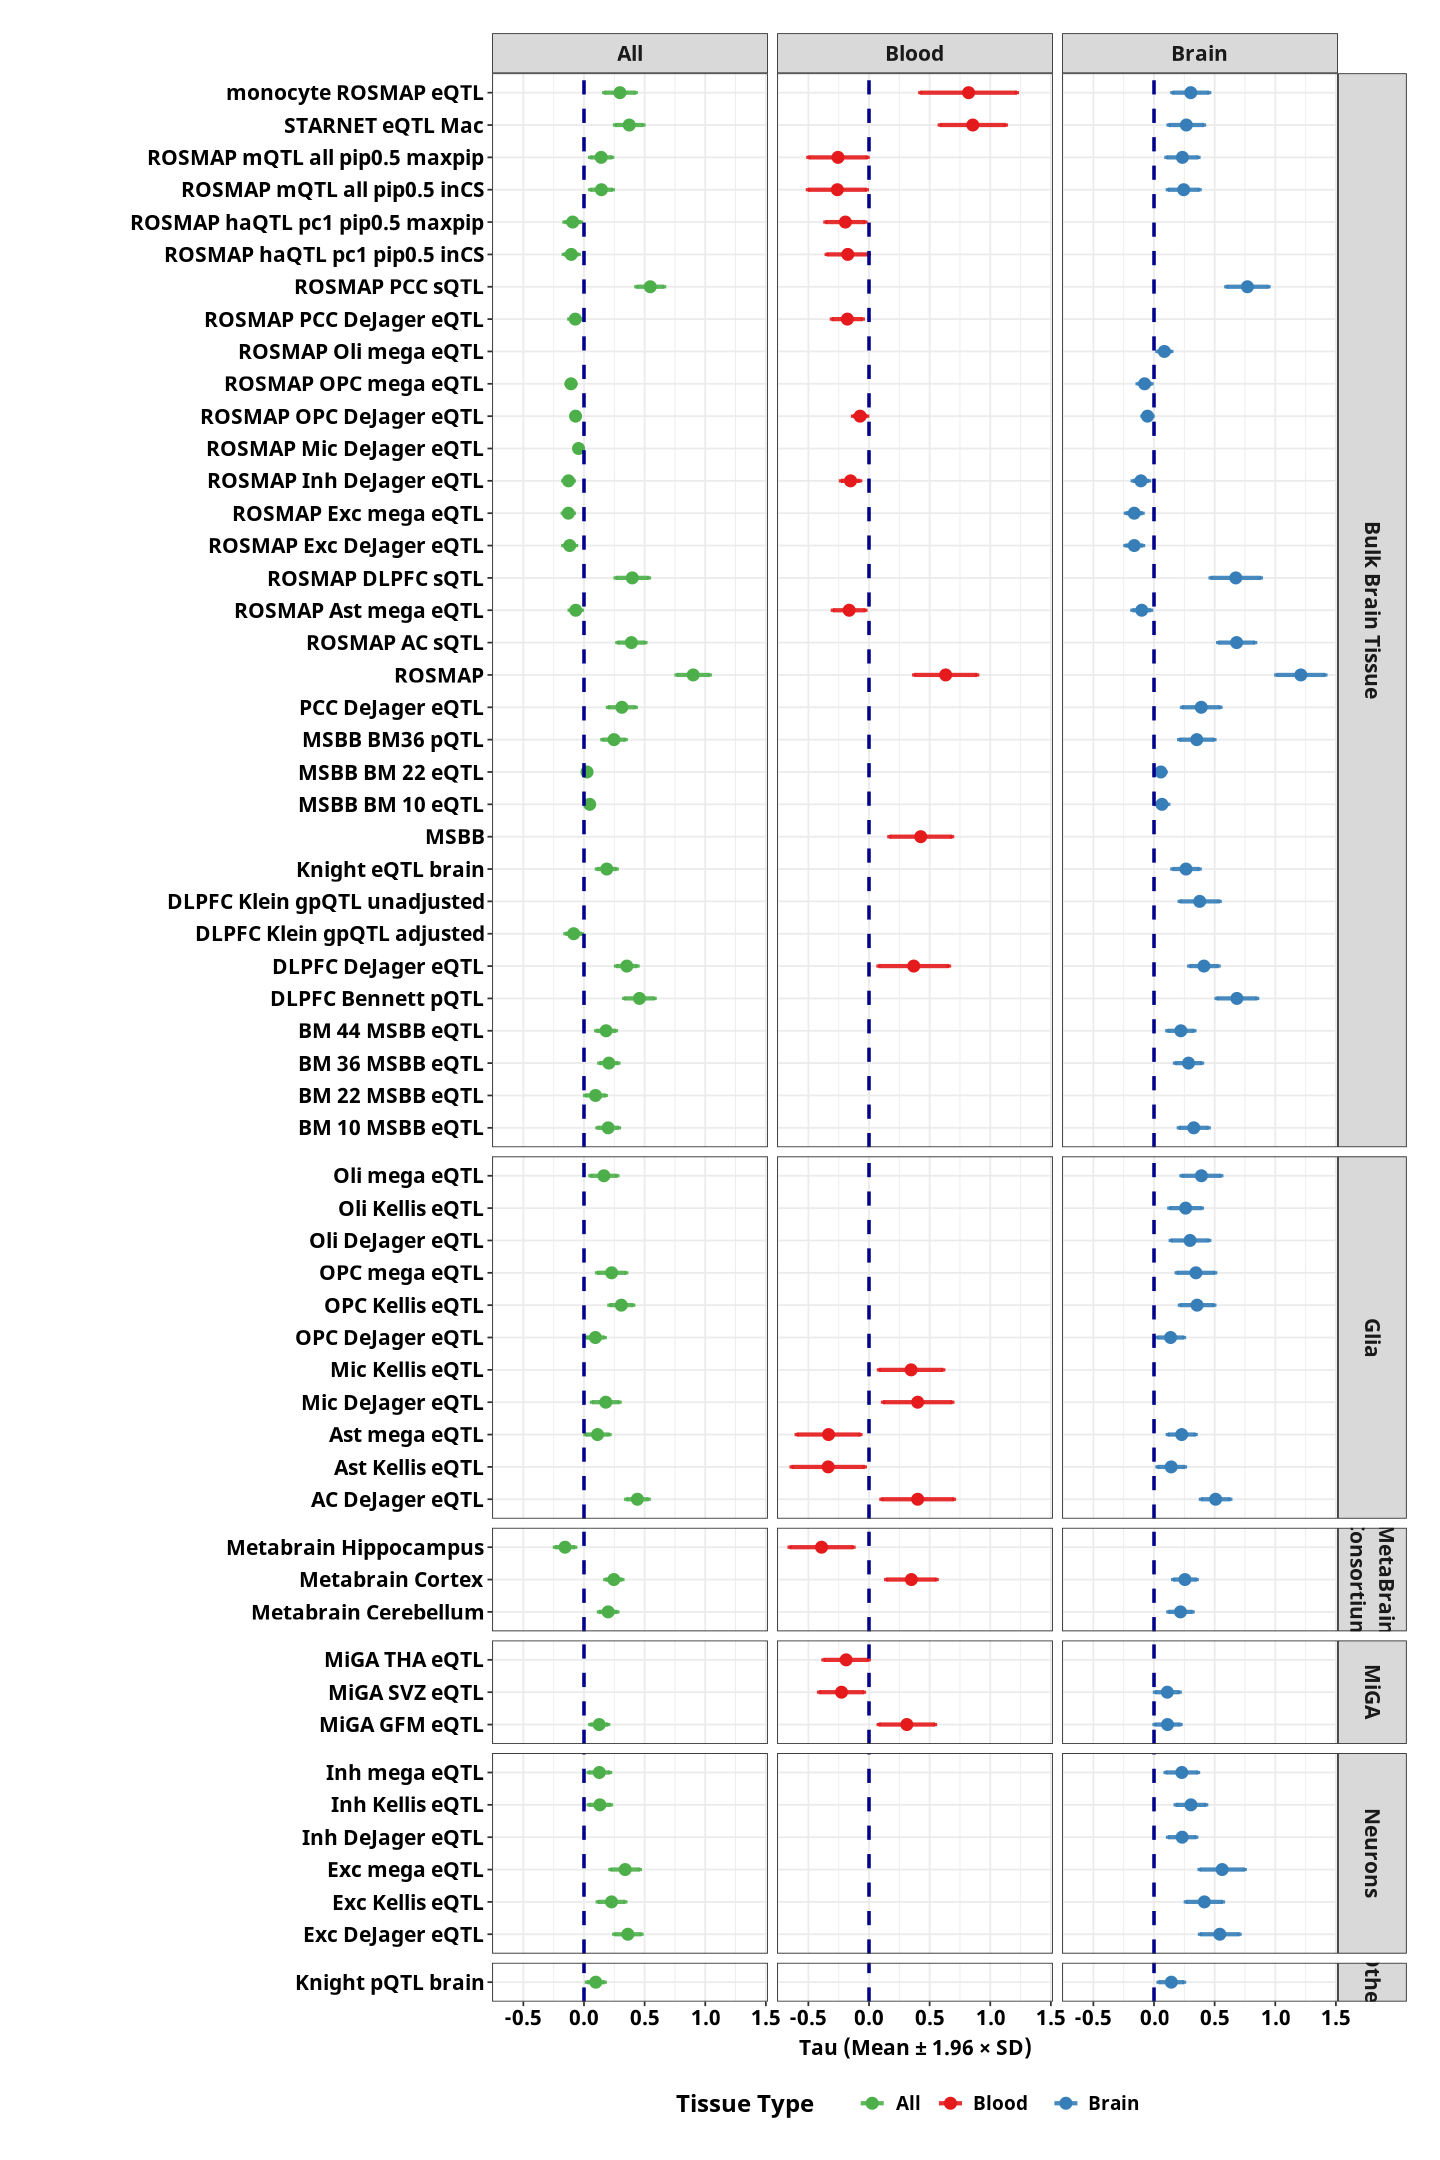

In [45]:
# Update p1 with tissue_group rows and tissue_type columns
p1 <- ggplot(
  tau.df_significant,
  aes(x = display_study, y = Mean,
      colour = tissue_type)
) +
  geom_point(position = position_dodge(width = 0.8), size = 3) +
  geom_errorbar(
    aes(ymin = Lower, ymax = Upper),
    position = position_dodge(width = 0.8),
    width = 0.1,
    linewidth = 1.2,
    alpha = 0.9
  ) +
  scale_color_manual(
    values = c("Blood" = "#E41A1C", "Brain" = "#377EB8", "All" = "#4DAF4A"),
    name = "Tissue Type"
  ) +
  geom_hline(yintercept = 0, linetype = 2, colour = "darkblue", linewidth = 1) +
  theme_bw() +
  theme(
    text = element_text(family = "Noto Sans", size = 18, face = "bold"),
    axis.text.x = element_text(size = 16, colour = "black"), 
    axis.text.y = element_text(size = 16, colour = "black", hjust = 1),
    axis.title.x = element_text(size = 16, colour = "black"),
    axis.title.y = element_blank(),
    strip.text = element_text(size = 16, face = "bold"),
    legend.position = "bottom",
    plot.margin = margin(20, 20, 20, 20)
  ) +
  ylab("Tau (Mean ± 1.96 × SD)") +
  # Facet with tissue_group on rows and tissue_type on columns
  facet_grid(tissue_group ~ tissue_type, scales = "free_y", space = "free_y") +
  coord_flip()

options(repr.plot.width = 12, repr.plot.height = 18)  # Wider for side-by-side facets
print(p1)

#### Enrichment

In [46]:
## Enrichment
reorder_levels <- enrich.df %>%
  filter(trait == "Brain") %>%          # choose reference trait
  arrange(desc(Mean)) %>%               # descending by Mean
  pull(study) %>%                       # get vector
  unique()

enrich.df$study <- factor(enrich.df$study, levels = reorder_levels)

## 5. Mark significance (95 % CI does NOT include zero) ---------
enrich.df <- enrich.df %>%
  mutate(signif = Lower * Upper > 0)

## Filter to show only significant results and add display names
enrich.df$display_study <- gsub("_", " ", enrich.df$study)

enrich.df_significant <- enrich.df %>% 
  filter(signif == TRUE) %>%
  mutate(tissue_type = case_when(
    trait == "Blood" ~ "Blood",
    trait == "Brain" ~ "Brain", 
    trait == "All" ~ "All",
    TRUE ~ "Other"
  ))

# Apply tissue grouping to enrichment data
enrich.df_significant <- enrich.df_significant %>%
  mutate(
    tissue_group = case_when(
      grepl("STARNET|ROSMAP|PCC|DLPFC|MSBB|Knight.*eQTL.*brain|AC.*CUIMC1|BM.*MSBB|PCC.*CUIMC1", study) ~ "Bulk Brain Tissue",
      grepl("Inh|Exc", study) ~ "Neurons",
      grepl("Knight.*pQTL|DLPFC.*Klein", study) ~ "Other",
      grepl("MIGA|MiGA", study) ~ "MiGA",
      grepl("Metabrain", study) ~ "MetaBrain\nConsortium",
      TRUE ~ "Glia"
    )
  )

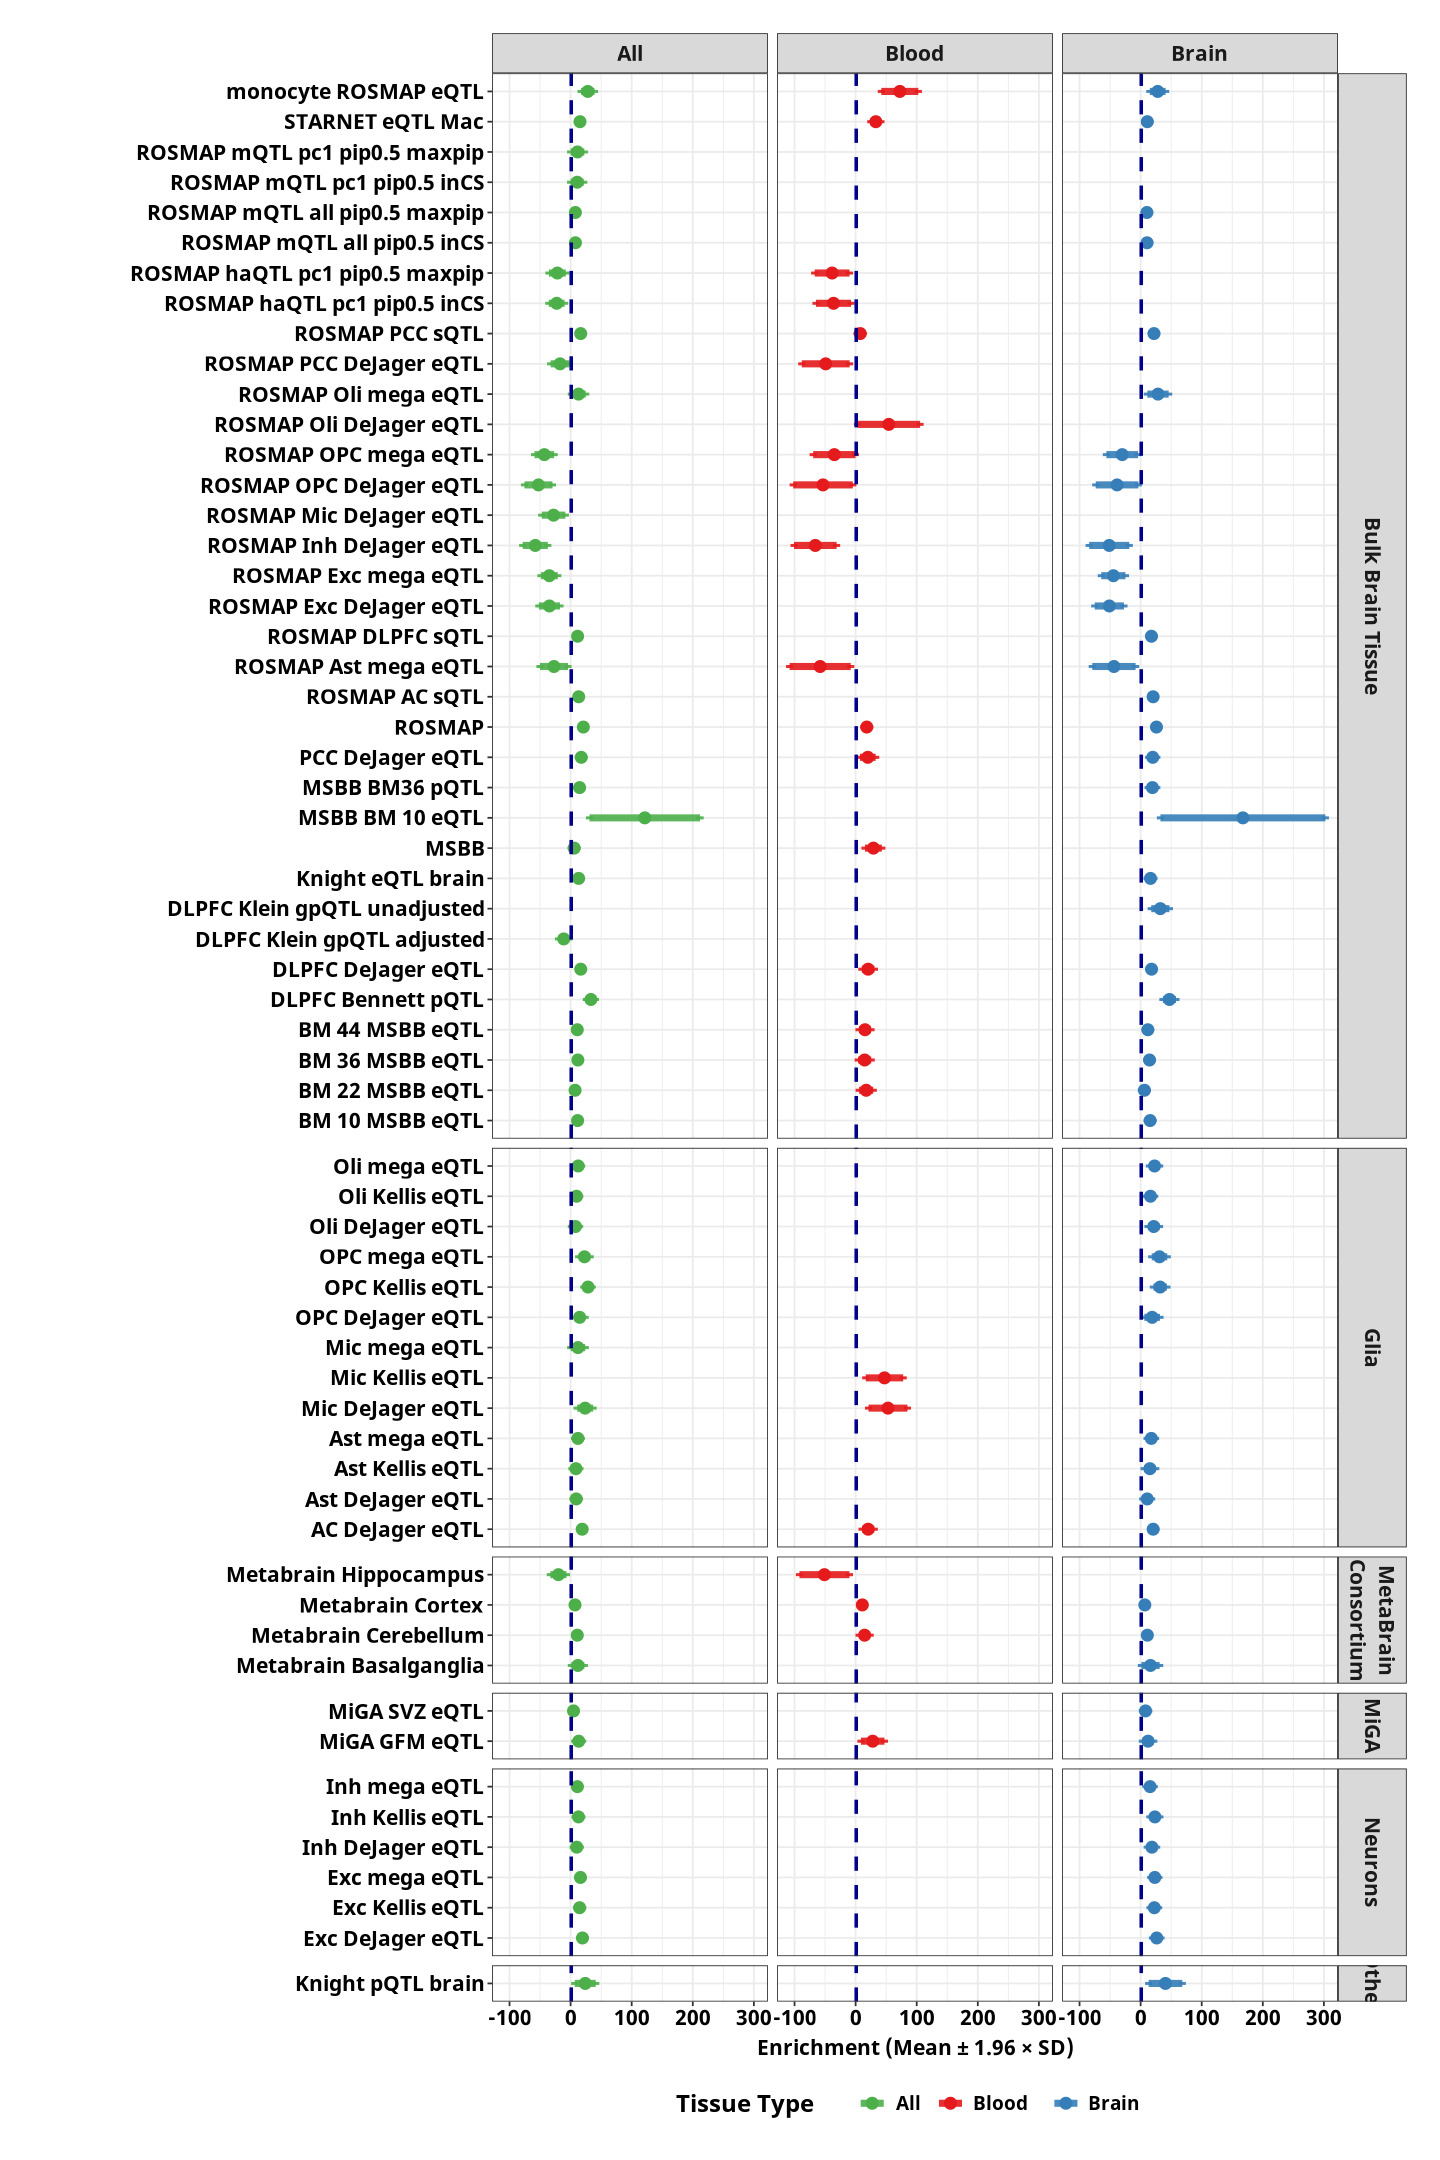

In [47]:
# Update p2 with tissue_group rows and tissue_type columns
p2 <- ggplot(
  enrich.df_significant,
  aes(x = display_study, y = Mean,
      colour = tissue_type)      
) +
  geom_point(position = position_dodge(width = 0.8), size = 3) +
  geom_errorbar(
    aes(ymin = Lower, ymax = Upper),
    position = position_dodge(width = 0.8),
    width = 0.1,
    linewidth = 2,
    alpha = 0.9
  ) +
  scale_color_manual(
    values = c("Blood" = "#E41A1C", "Brain" = "#377EB8", "All" = "#4DAF4A"),
    name = "Tissue Type"
  ) +
  geom_hline(yintercept = 1, linetype = 2, colour = "darkblue", linewidth = 1) +
  theme_bw() +
  theme(
    text = element_text(family = "Noto Sans", size = 18, face = "bold"),
    axis.text.x = element_text(size = 16, colour = "black"), 
    axis.text.y = element_text(size = 16, colour = "black", hjust = 1),
    axis.title.x = element_text(size = 16, colour = "black"),
    axis.title.y = element_blank(),
    strip.text = element_text(size = 16, face = "bold"),
    legend.position = "bottom",
    plot.margin = margin(20, 20, 20, 20)
  ) +
  ylab("Enrichment (Mean ± 1.96 × SD)") +
  # Facet with tissue_group on rows and tissue_type on columns
  facet_grid(tissue_group ~ tissue_type, scales = "free_y", space = "free_y") +
  coord_flip()

options(repr.plot.width = 12, repr.plot.height = 18)
print(p2)

#### Plot 3

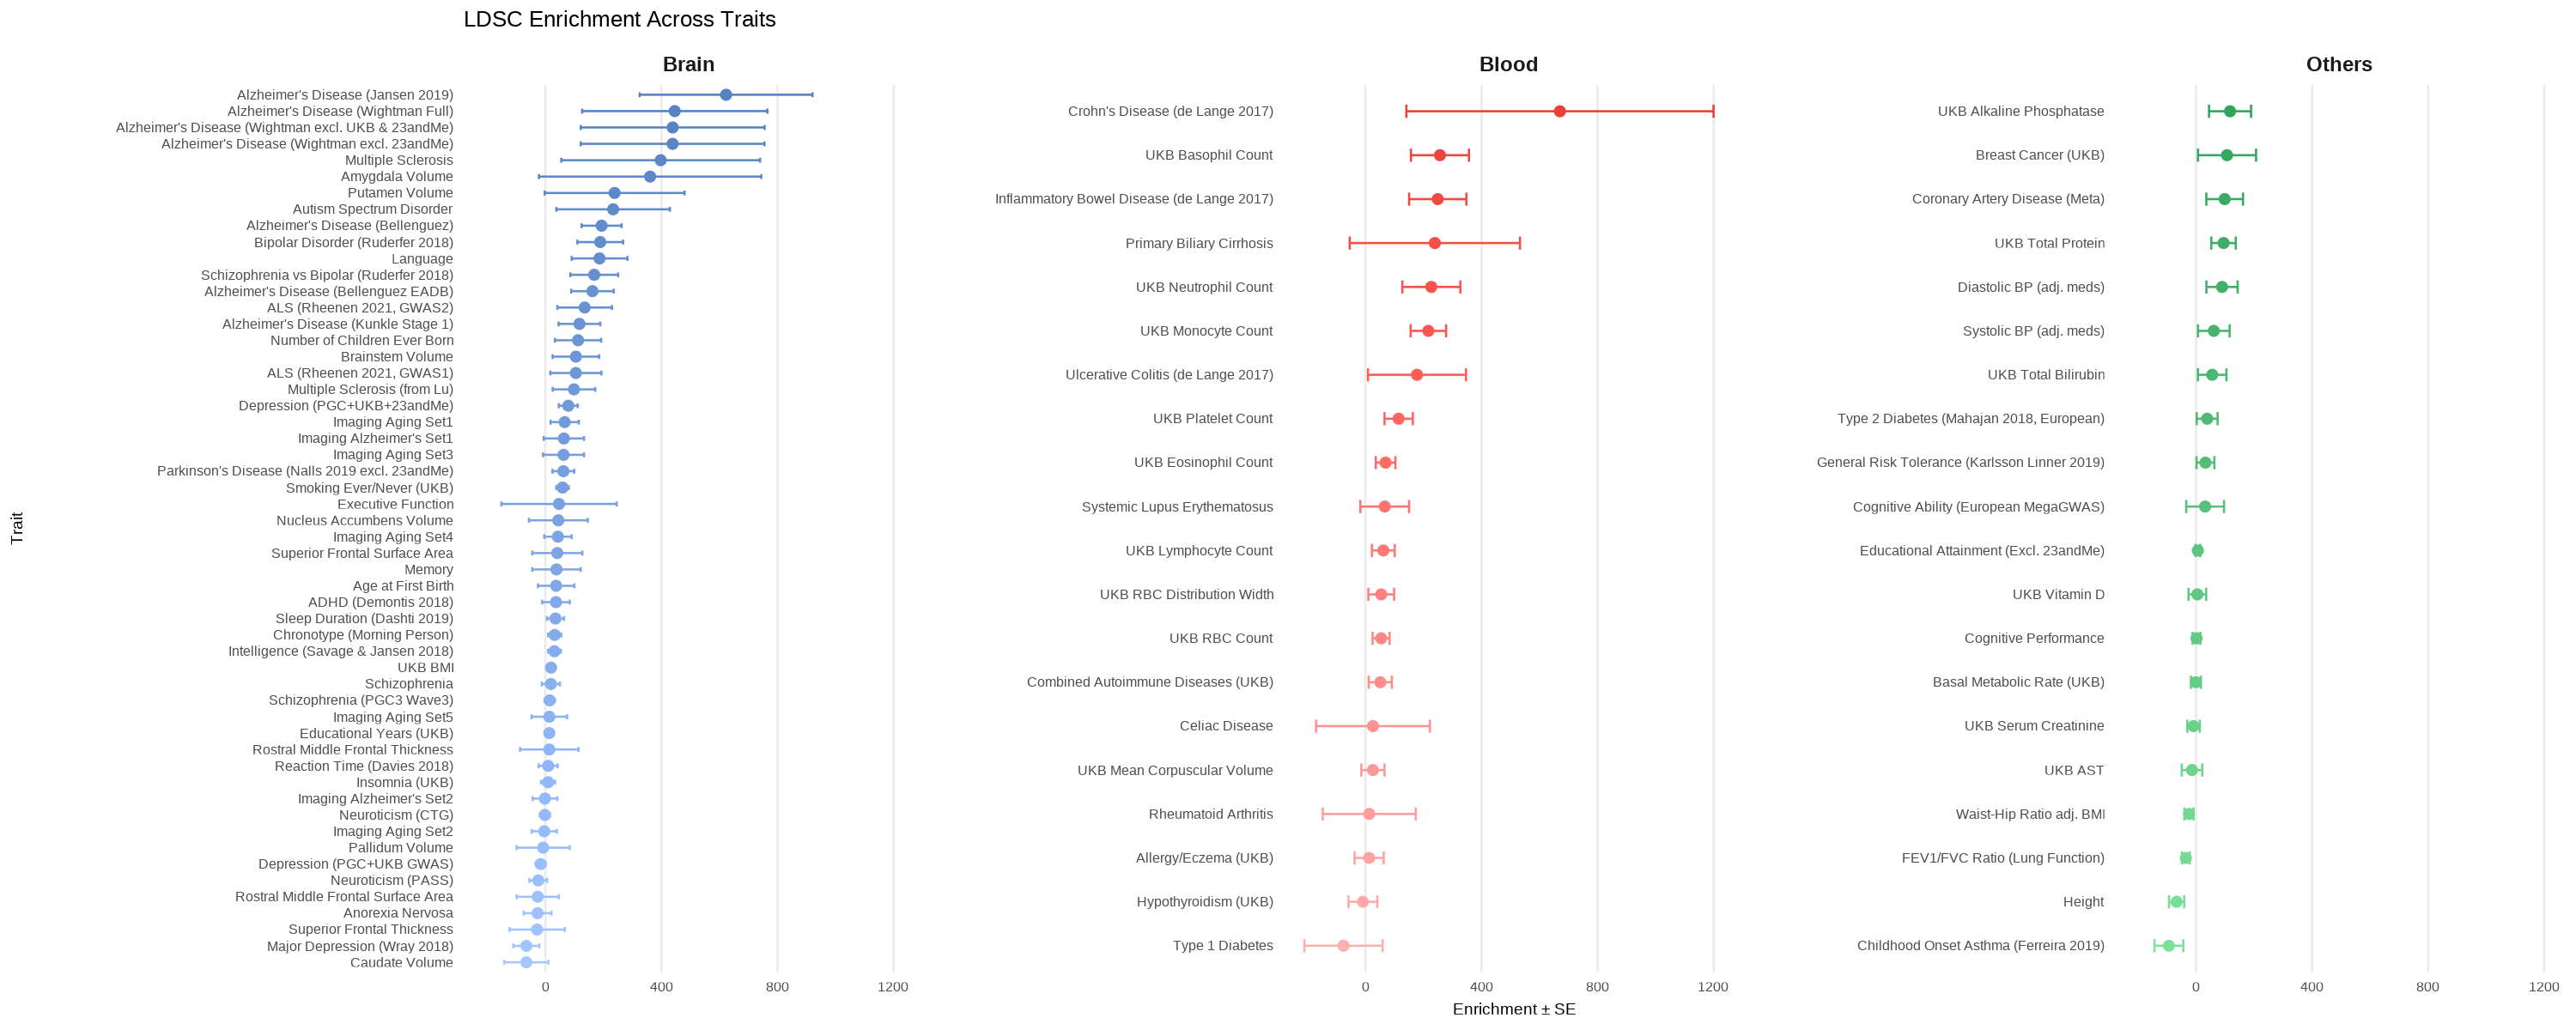

In [25]:
options(repr.plot.width = 25, repr.plot.height = 10)

category_colors <- c(
  "Blood" = "#4575B4",     # 
  "Brain" = "#D73027",     # 
  "All" = "#1A9850",    # 
  "Others" = "#984EA3"      # others
)

# Assign colors by category (soft variations within each)
traits_dt <- traits_dt %>%
  group_by(category) %>%
  mutate(
    trait_order = as.integer(factor(trait, levels = unique(trait[order(enrichment)]))),
    n_traits = n(),
    color = lighten(category_colors[category], 
                    amount = scales::rescale(trait_order, to = c(0.6, 0.1)))
  ) %>%
  ungroup()

ggplot(traits_dt, aes(x = reorder(trait, enrichment), y = enrichment, color = trait)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = enrichment - se, ymax = enrichment + se), width = 0.3) +
  coord_flip() +
  facet_wrap(~category, scales = 'free_y') +
  labs(
    title = "LDSC Enrichment Across Traits",
    x = "Trait",
    y = "Enrichment ± SE"
  ) +
  scale_color_manual(values = setNames(traits_dt$color, traits_dt$trait)) +
  theme_minimal(base_size = 16) +
  theme(
    strip.text = element_text(face = "bold", size = 18),
    axis.text.y = element_text(size = 12),
    axis.text.x = element_text(size = 12),
    axis.title = element_text(size = 14),
    legend.position = "none",
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_blank()
  )